<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


🚀 Using Device: cuda

🚀 Simulating Additive White Gaussian Noise Channel

🔍 Analyzing List Size: 1
Simulating at SNR: -2.00 dB with List Size 1
🔢 Polar Code Parameters:
- Total Length (N): 32
- Information Bits (K): 16
- Coding Rate (R = K/N): 0.5000
- CRC Type: CRC-7

📊 Dataset Preparation Diagnostics:
Channel Type: AWGN
List Size: 1
SNR (dB): -2.0
Input Tensor Shape (X): (10000, 32)
Label Tensor Shape (y): (10000, 16)
Input Data Type: float64
Label Data Type: int64

🔍 Dataset Statistical Overview:
Input Features:
- Mean: 0.6175
- Std Dev: 0.4860
- Min: 0.0
- Max: 1.0

Labels:
- Mean: 0.4986
- Unique Values: [0 1]


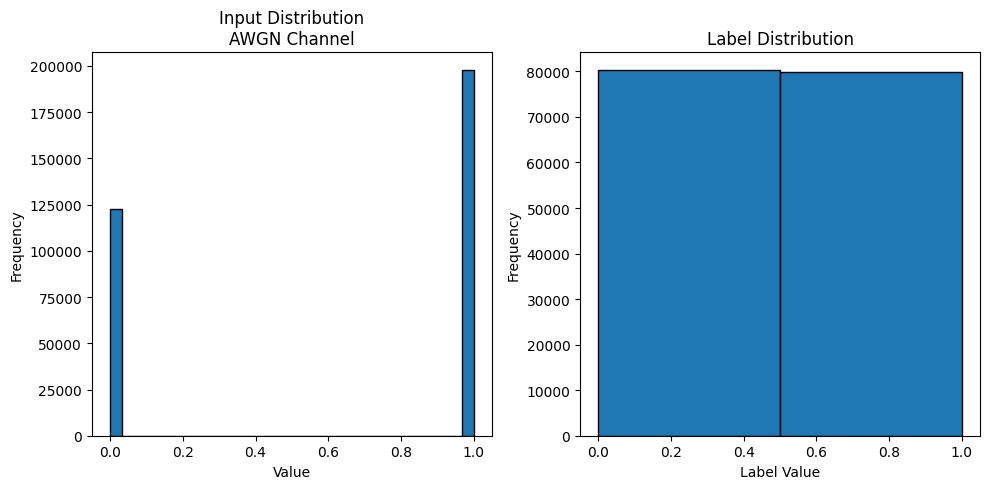

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔍 Tensor Preprocessing:
X shape: torch.Size([8000, 32])
y shape: torch.Size([8000])
X dtype: torch.float32
y dtype: torch.float32
Epoch [1/50], Train Loss: 0.7006, Val Loss: 0.6935
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6933
Epoch [3/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [4/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [5/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [7/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [8/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [9/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [10/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [11/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [12/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [13/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [14/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [15/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [16/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [17/50], Train Loss: 0.6931, Val Loss: 0

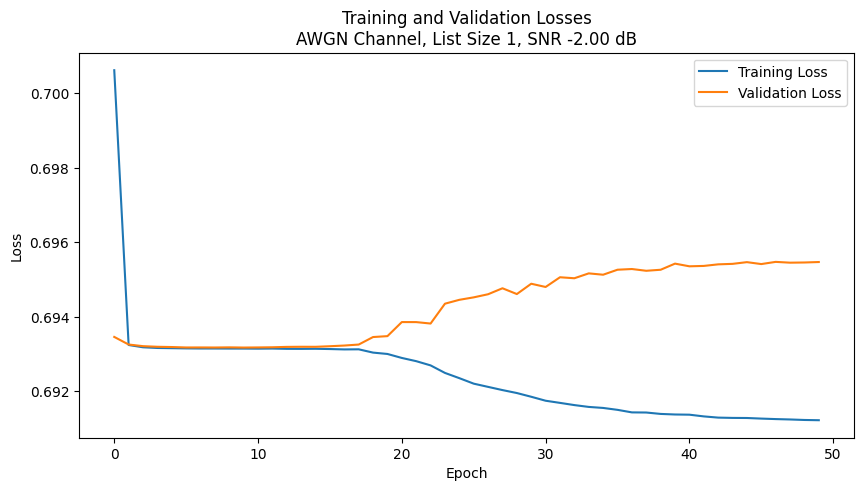

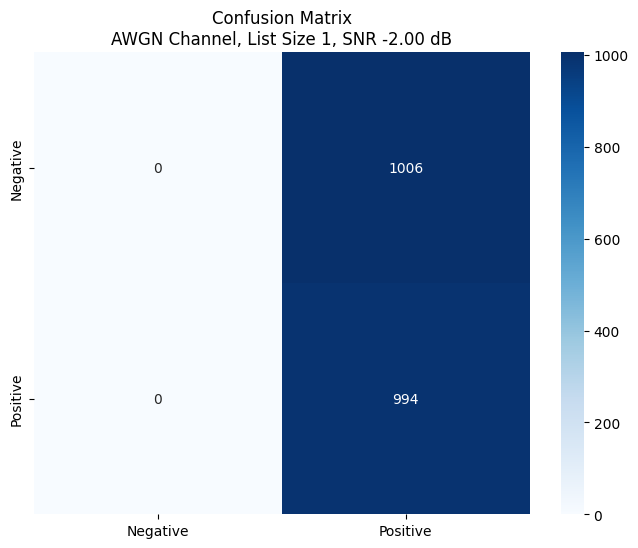

List Size 1, SNR -2.00 dB:
- Bit Error Rate (BER): 0.503000
- Block Error Rate (BLER): 0.503000
Simulating at SNR: -1.22 dB with List Size 1
🔢 Polar Code Parameters:
- Total Length (N): 32
- Information Bits (K): 16
- Coding Rate (R = K/N): 0.5000
- CRC Type: CRC-7

📊 Dataset Preparation Diagnostics:
Channel Type: AWGN
List Size: 1
SNR (dB): -1.2222222222222223
Input Tensor Shape (X): (10000, 32)
Label Tensor Shape (y): (10000, 16)
Input Data Type: float64
Label Data Type: int64

🔍 Dataset Statistical Overview:
Input Features:
- Mean: 0.6216
- Std Dev: 0.4850
- Min: 0.0
- Max: 1.0

Labels:
- Mean: 0.4998
- Unique Values: [0 1]


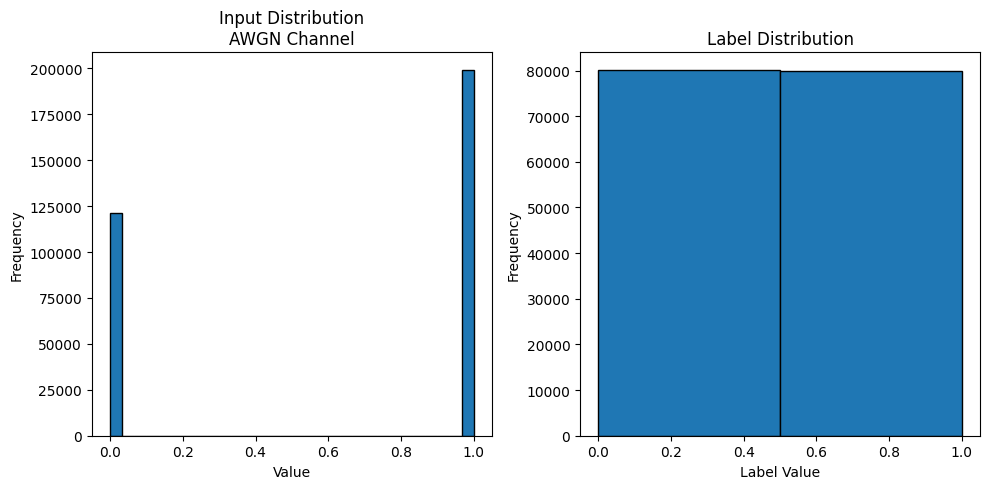

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔍 Tensor Preprocessing:
X shape: torch.Size([8000, 32])
y shape: torch.Size([8000])
X dtype: torch.float32
y dtype: torch.float32
Epoch [1/50], Train Loss: 0.6977, Val Loss: 0.6931
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [3/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [4/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [5/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [7/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [8/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [9/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [10/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [11/50], Train Loss: 0.6930, Val Loss: 0.6932
Epoch [12/50], Train Loss: 0.6930, Val Loss: 0.6932
Epoch [13/50], Train Loss: 0.6928, Val Loss: 0.6933
Epoch [14/50], Train Loss: 0.6926, Val Loss: 0.6936
Epoch [15/50], Train Loss: 0.6924, Val Loss: 0.6936
Epoch [16/50], Train Loss: 0.6921, Val Loss: 0.6937
Epoch [17/50], Train Loss: 0.6918, Val Loss: 0

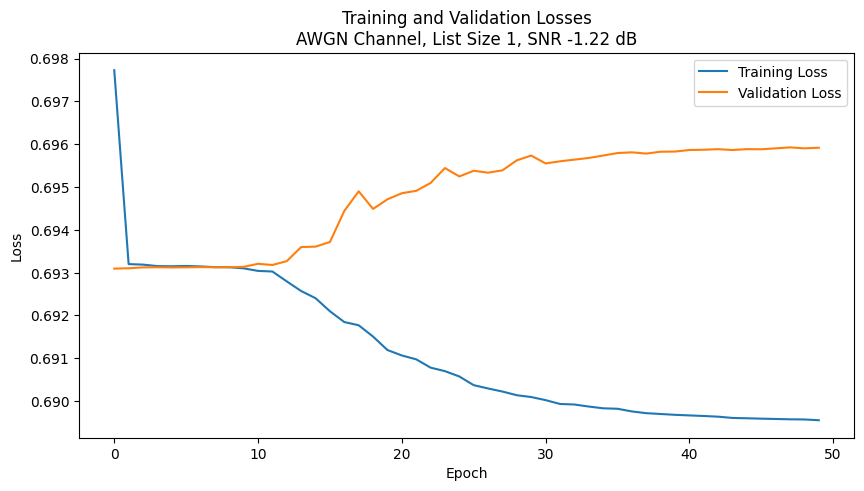

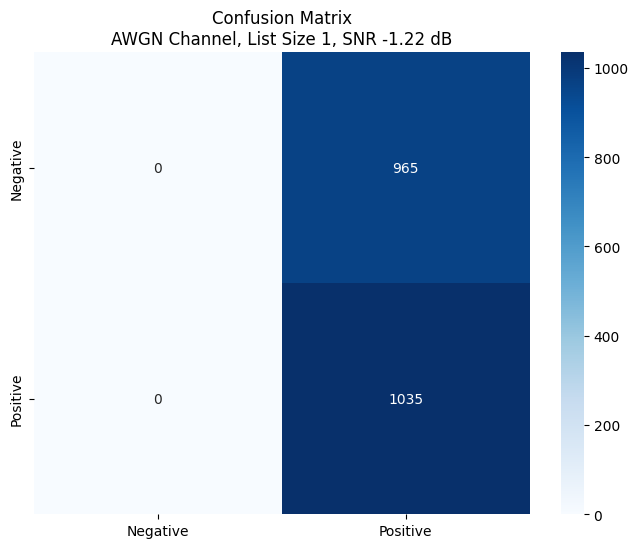

List Size 1, SNR -1.22 dB:
- Bit Error Rate (BER): 0.482500
- Block Error Rate (BLER): 0.482500
Simulating at SNR: -0.44 dB with List Size 1
🔢 Polar Code Parameters:
- Total Length (N): 32
- Information Bits (K): 16
- Coding Rate (R = K/N): 0.5000
- CRC Type: CRC-7

📊 Dataset Preparation Diagnostics:
Channel Type: AWGN
List Size: 1
SNR (dB): -0.4444444444444444
Input Tensor Shape (X): (10000, 32)
Label Tensor Shape (y): (10000, 16)
Input Data Type: float64
Label Data Type: int64

🔍 Dataset Statistical Overview:
Input Features:
- Mean: 0.6292
- Std Dev: 0.4830
- Min: 0.0
- Max: 1.0

Labels:
- Mean: 0.4990
- Unique Values: [0 1]


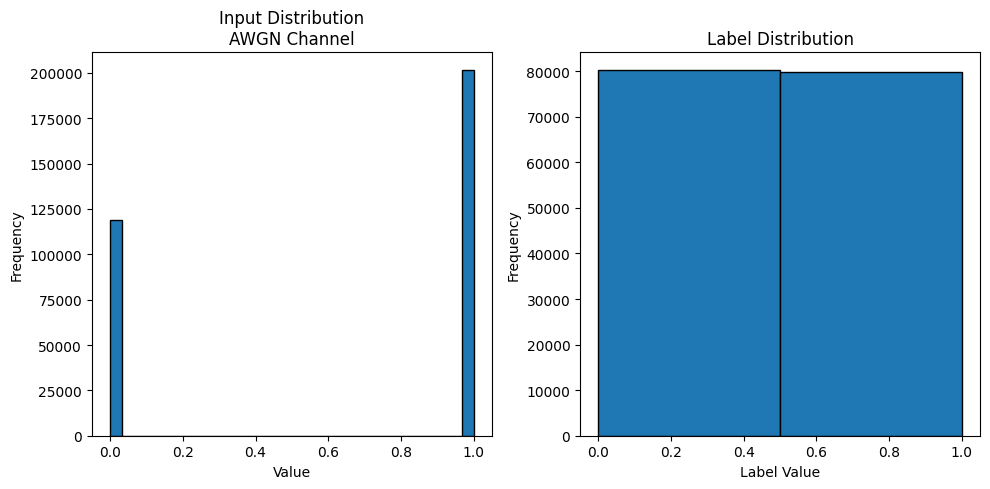

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔍 Tensor Preprocessing:
X shape: torch.Size([8000, 32])
y shape: torch.Size([8000])
X dtype: torch.float32
y dtype: torch.float32
Epoch [1/50], Train Loss: 0.6966, Val Loss: 0.6930
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [3/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [4/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [5/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [7/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [8/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [9/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [10/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [11/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [12/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [13/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [14/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [15/50], Train Loss: 0.6932, Val Loss: 0.6931
Epoch [16/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [17/50], Train Loss: 0.6931, Val Loss: 0

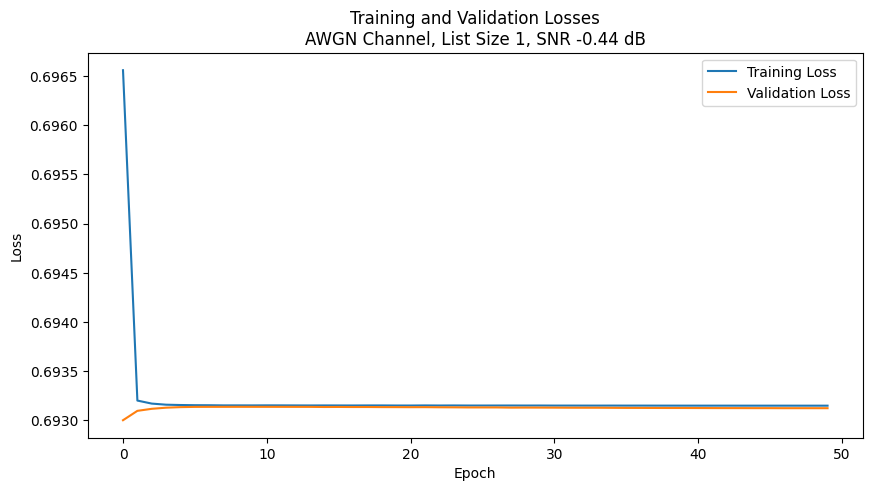

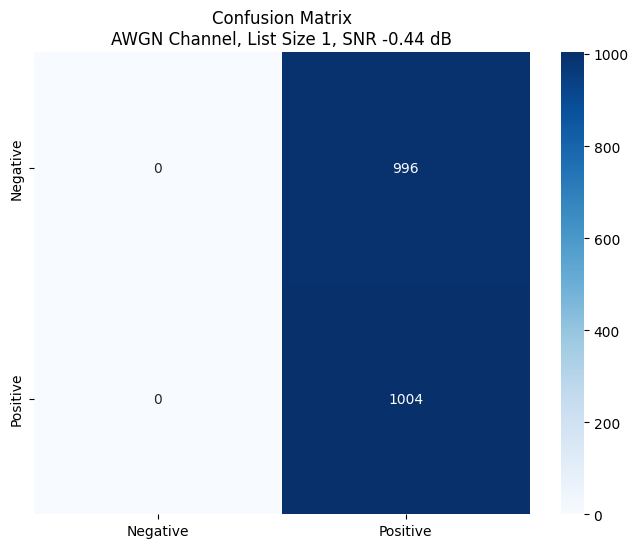

List Size 1, SNR -0.44 dB:
- Bit Error Rate (BER): 0.498000
- Block Error Rate (BLER): 0.498000
Simulating at SNR: 0.33 dB with List Size 1
🔢 Polar Code Parameters:
- Total Length (N): 32
- Information Bits (K): 16
- Coding Rate (R = K/N): 0.5000
- CRC Type: CRC-7

📊 Dataset Preparation Diagnostics:
Channel Type: AWGN
List Size: 1
SNR (dB): 0.3333333333333335
Input Tensor Shape (X): (10000, 32)
Label Tensor Shape (y): (10000, 16)
Input Data Type: float64
Label Data Type: int64

🔍 Dataset Statistical Overview:
Input Features:
- Mean: 0.6335
- Std Dev: 0.4818
- Min: 0.0
- Max: 1.0

Labels:
- Mean: 0.5007
- Unique Values: [0 1]


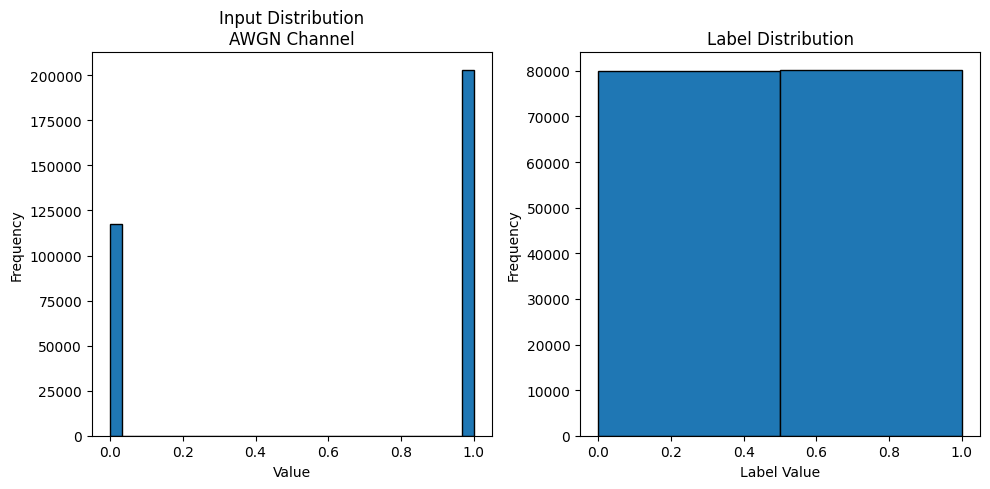

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔍 Tensor Preprocessing:
X shape: torch.Size([8000, 32])
y shape: torch.Size([8000])
X dtype: torch.float32
y dtype: torch.float32
Epoch [1/50], Train Loss: 0.6985, Val Loss: 0.6934
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [3/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [4/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [5/50], Train Loss: 0.6931, Val Loss: 0.6931
Epoch [6/50], Train Loss: 0.6930, Val Loss: 0.6932
Epoch [7/50], Train Loss: 0.6927, Val Loss: 0.6936
Epoch [8/50], Train Loss: 0.6922, Val Loss: 0.6939
Epoch [9/50], Train Loss: 0.6918, Val Loss: 0.6943
Epoch [10/50], Train Loss: 0.6909, Val Loss: 0.6944
Epoch [11/50], Train Loss: 0.6907, Val Loss: 0.6946
Epoch [12/50], Train Loss: 0.6903, Val Loss: 0.6953
Epoch [13/50], Train Loss: 0.6901, Val Loss: 0.6956
Epoch [14/50], Train Loss: 0.6898, Val Loss: 0.6952
Epoch [15/50], Train Loss: 0.6895, Val Loss: 0.6965
Epoch [16/50], Train Loss: 0.6892, Val Loss: 0.6959
Epoch [17/50], Train Loss: 0.6888, Val Loss: 0

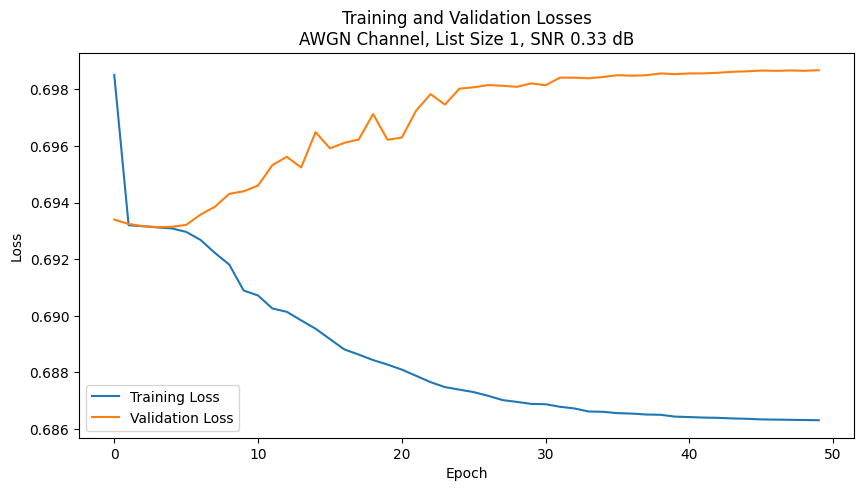

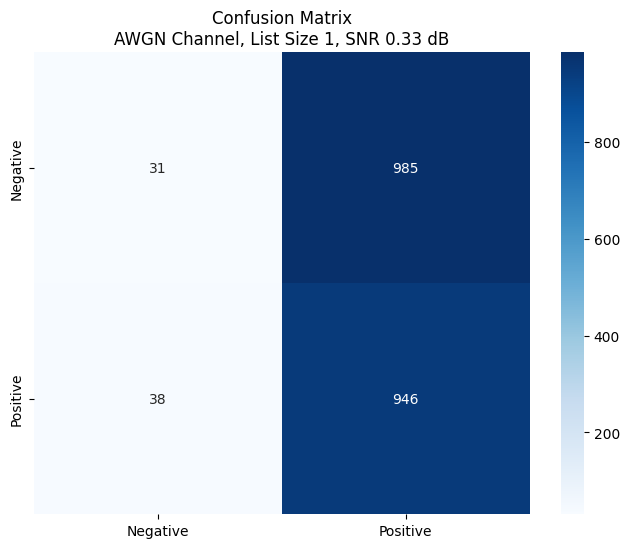

List Size 1, SNR 0.33 dB:
- Bit Error Rate (BER): 0.511500
- Block Error Rate (BLER): 0.511500
Simulating at SNR: 1.11 dB with List Size 1
🔢 Polar Code Parameters:
- Total Length (N): 32
- Information Bits (K): 16
- Coding Rate (R = K/N): 0.5000
- CRC Type: CRC-7

📊 Dataset Preparation Diagnostics:
Channel Type: AWGN
List Size: 1
SNR (dB): 1.1111111111111112
Input Tensor Shape (X): (10000, 32)
Label Tensor Shape (y): (10000, 16)
Input Data Type: float64
Label Data Type: int64

🔍 Dataset Statistical Overview:
Input Features:
- Mean: 0.6402
- Std Dev: 0.4799
- Min: 0.0
- Max: 1.0

Labels:
- Mean: 0.4997
- Unique Values: [0 1]


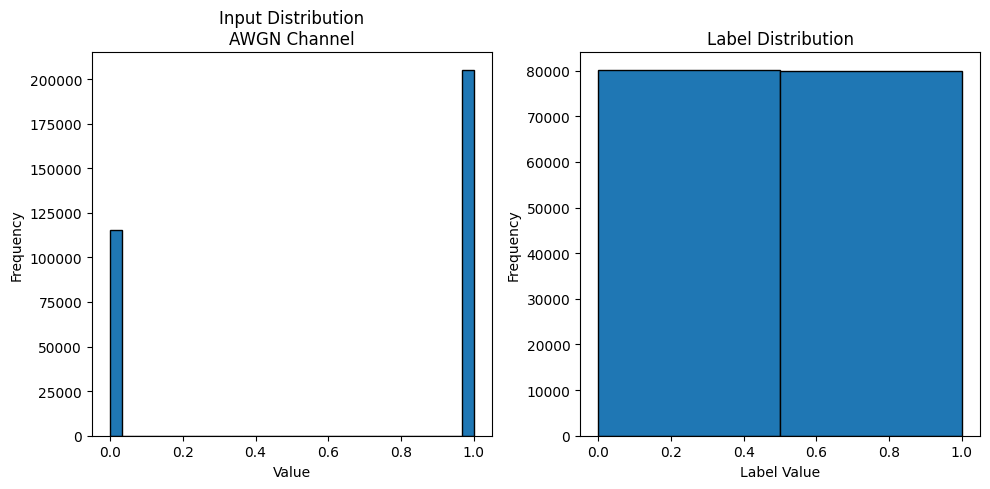

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🔍 Tensor Preprocessing:
X shape: torch.Size([8000, 32])
y shape: torch.Size([8000])
X dtype: torch.float32
y dtype: torch.float32
Epoch [1/50], Train Loss: 0.6989, Val Loss: 0.6934
Epoch [2/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [3/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [4/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [5/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [6/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [7/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [8/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [9/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [10/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [11/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [12/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [13/50], Train Loss: 0.6932, Val Loss: 0.6932
Epoch [14/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [15/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [16/50], Train Loss: 0.6931, Val Loss: 0.6932
Epoch [17/50], Train Loss: 0.6931, Val Loss: 0

In [ ]:
#Comprehensive Polar Code Simulation Framework

# Essential Scientific and Deep Learning Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Machine Learning and Data Handling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Visualization and Scientific Computing
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps

# System and Utilities
import logging
import traceback
import sys

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s]: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")
#Part 2
class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        """
        Polar Code Generator with CRC support

        Args:
            N (int): Total code length
            K (int): Information bit length
            crc_type (str): CRC polynomial type
        """
        self.N = N
        self.K = K
        self.crc_type = crc_type

        # Coding Rate Calculation
        self.rate = K / N

        # CRC Polynomials
        self.crc_polynomials = {
            'CRC-7': {
                'polynomial': [1, 1, 1, 0, 0, 1, 1],
                'length': 7
            }
        }

        # Print Code Parameters
        print(f"🔢 Polar Code Parameters:")
        print(f"- Total Length (N): {N}")
        print(f"- Information Bits (K): {K}")
        print(f"- Coding Rate (R = K/N): {self.rate:.4f}")
        print(f"- CRC Type: {crc_type}")

    def generate_info_bits(self):
        """
        Generate random information bits

        Returns:
            np.ndarray: Random information bits
        """
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        """
        Compute CRC checksum using polynomial division

        Args:
            bits (np.ndarray): Input bits

        Returns:
            np.ndarray: CRC checksum bits
        """
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']

        # Convert input to list and pad
        message = bits.tolist() + [0] * crc_length

        # Polynomial long division
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        # Return the last 'crc_length' bits
        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        """
        Polar Code Encoding with CRC

        Args:
            info_bits (np.ndarray): Information bits

        Returns:
            np.ndarray: Encoded codeword
        """
        # Append CRC
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])

        # Basic polar encoding (placeholder)
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits

        return codeword

    def verify_codeword(self, codeword):
        """
        Verify codeword using CRC

        Args:
            codeword (np.ndarray): Received codeword

        Returns:
            bool: True if CRC check passes, False otherwise
        """
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        crc_length = poly_info['length']

        # Extract information and CRC bits
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]

        # Compute CRC of information bits
        computed_crc = self.compute_crc(info_bits)

        # Compare received and computed CRC
        return np.array_equal(received_crc, computed_crc)

# Part 3

class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        """
        Advanced Channel Simulator for communication systems

        Args:
            channel_type (str): Channel type ('AWGN' or 'Rayleigh')
        """
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db, list_size=1):
        """
        Simulate signal transmission through specified channel with list decoding support

        Args:
            encoded_signal (np.ndarray): Input encoded signal
            snr_db (float): Signal-to-Noise Ratio in decibels
            list_size (int): Number of list decoding iterations

        Returns:
            np.ndarray: Received signal after channel effects
        """
        try:
            # Convert input to numpy array
            encoded_signal = np.array(encoded_signal, dtype=float)

            # Convert bits {0,1} to BPSK: {+1, -1}
            bpsk_signal = 1 - 2 * encoded_signal

            # Convert SNR from dB to linear scale
            snr_linear = 10 ** (snr_db / 10)

            # Compute signal power
            signal_power = np.mean(bpsk_signal**2)

            # Noise power calculation
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            # List decoding simulation
            received_signals = []
            for _ in range(list_size):
                # Channel-specific simulation
                if self.channel_type == 'AWGN':
                    # Additive White Gaussian Noise
                    noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                    received_signal = bpsk_signal + noise

                elif self.channel_type == 'Rayleigh':
                    # Rayleigh Fading Channel
                    fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                    noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                    received_signal = fading * bpsk_signal + noise

                else:
                    raise ValueError(f"Unsupported channel type: {self.channel_type}")

                received_signals.append(received_signal)

            # Majority voting for list decoding
            final_received_signal = np.mean(received_signals, axis=0)

            # Convert back to binary representation
            return (final_received_signal > 0).astype(float)

        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            return encoded_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        """
        Compute theoretical Bit Error Probability (BEP) and Block Error Probability (BLER)

        Args:
            block_length (int): Length of the code block
            snr_linear (np.ndarray): SNR in linear scale

        Returns:
            tuple: Theoretical BEP and BLER
        """
        try:
            if self.channel_type == 'AWGN':
                # AWGN Channel Theoretical Performance
                # Bit Error Probability using Q-function
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))

            elif self.channel_type == 'Rayleigh':
                # Rayleigh Fading Channel Theoretical Performance
                # Average Bit Error Probability for Rayleigh fading
                bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))

            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Block Error Probability (assuming independent bit errors)
            bler = 1 - (1 - bep) ** block_length

            return bep, bler

        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            # Return default values if computation fails
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)

    def plot_channel_capacity(self, snr_range):
        """
        Plot channel capacity for the specific channel type

        Args:
            snr_range (np.ndarray): Range of SNR values in dB
        """
        plt.figure(figsize=(10, 6))

        # Compute channel capacities
        snr_linear = 10 ** (snr_range / 10)
        capacities = [np.log2(1 + snr) for snr in snr_linear]

        plt.plot(snr_range, capacities, label=f'{self.channel_type} Channel')
        plt.title(f'Channel Capacity - {self.channel_type} Channel')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Capacity (bits/channel use)')
        plt.grid(True)
        plt.legend()

# Part 4

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type="AWGN", list_size=1):
    """
    Prepare dataset for Polar Code simulation with robust preprocessing

    Args:
        polar_code_gen (PolarCodeGenerator): Polar code generator
        num_samples (int): Number of samples to generate
        snr_db (float): Signal-to-Noise Ratio in dB
        channel_type (str): Channel type
        list_size (int): List decoding size

    Returns:
        tuple: Input features and corresponding labels
    """
    # Create channel simulator
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)

    # Initialize storage
    X = []
    y = []

    for _ in range(num_samples):
        # Generate information bits
        info_bits = polar_code_gen.generate_info_bits()

        # Encode polar code
        encoded_signal = polar_code_gen.polar_encode(info_bits)

        # Channel simulation with list decoding
        received_signal = channel_simulator.simulate(
            encoded_signal,
            snr_db=snr_db,
            list_size=list_size
        )

        # Store features and labels
        X.append(received_signal)
        y.append(info_bits)  # Use original info_bits as target

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Comprehensive dataset diagnostics
    print("\n📊 Dataset Preparation Diagnostics:")
    print(f"Channel Type: {channel_type}")
    print(f"List Size: {list_size}")
    print(f"SNR (dB): {snr_db}")
    print(f"Input Tensor Shape (X): {X.shape}")
    print(f"Label Tensor Shape (y): {y.shape}")
    print(f"Input Data Type: {X.dtype}")
    print(f"Label Data Type: {y.dtype}")

    # Additional statistical insights
    print("\n🔍 Dataset Statistical Overview:")
    print("Input Features:")
    print(f"- Mean: {X.mean():.4f}")
    print(f"- Std Dev: {X.std():.4f}")
    print(f"- Min: {X.min()}")
    print(f"- Max: {X.max()}")

    print("\nLabels:")
    print(f"- Mean: {y.mean():.4f}")
    print(f"- Unique Values: {np.unique(y)}")

    # Optional: Visualize input distribution
    plt.figure(figsize=(10, 5))

    # Input Distribution
    plt.subplot(1, 2, 1)
    plt.hist(X.flatten(), bins=30, edgecolor='black')
    plt.title(f'Input Distribution\n{channel_type} Channel')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Label Distribution
    plt.subplot(1, 2, 2)
    plt.hist(y.flatten(), bins=2, edgecolor='black')
    plt.title('Label Distribution')
    plt.xlabel('Label Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return X, y

######################################################

# Clas Decoder Trainer
class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        """
        Comprehensive Decoder Trainer
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

        # Use BCEWithLogitsLoss with reduction='mean'
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')

        # Optimizer with weight decay
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=1e-5
        )

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )

        # Training tracking
        self.train_losses = []
        self.val_losses = []

    def _preprocess_tensors(self, X, y):
        """
        Comprehensive tensor preprocessing
        """
        # Ensure X is a tensor
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)

        # Ensure y is a tensor
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)

        # Flatten multi-dimensional inputs
        if X.dim() > 2:
            X = X.view(X.size(0), -1)

        # Ensure y is 1D tensor
        y = y.view(-1)

        # Move to device
        X = X.to(self.device)
        y = y.to(self.device)

        # Diagnostic print
        print("\n🔍 Tensor Preprocessing:")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        print(f"X dtype: {X.dtype}")
        print(f"y dtype: {y.dtype}")

        return X, y

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        """
        Enhanced training method with built-in validation split
        """
        # Preprocess tensors
        X, y = self._preprocess_tensors(X, y)

        # Split into train and validation
        train_size = int((1 - validation_split) * len(X))
        X_val, y_val = X[train_size:], y[train_size:]
        X_train, y_train = X[:train_size], y[:train_size]

        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        # Reset loss tracking
        self.train_losses = []
        self.val_losses = []

        # Training loop
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            # Validation phase
            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Print progress
            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        """
        Train for one epoch
        """
        total_loss = 0
        for batch_X, batch_y in dataloader:
            # Ensure correct device
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(batch_X)

            # Reshape batch_y to match outputs shape
            batch_y = batch_y.float().view_as(outputs)

            # Compute loss
            loss = self.criterion(outputs, batch_y)

            # Backward pass
            loss.backward()

            # Optimize
            self.optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        """
        Validate model performance
        """
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                # Move to device
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                # Forward pass
                outputs = self.model(batch_X)

                # Reshape batch_y to match outputs shape
                batch_y = batch_y.float().view_as(outputs)

                # Compute loss
                loss = self.criterion(outputs, batch_y)

                # Accumulate loss
                total_loss += loss.item()

        return total_loss / len(dataloader)

    def predict(self, X):
        """
        Make predictions with comprehensive error handling
        """
        try:
            # Ensure input is a tensor
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)

            # Flatten multi-dimensional inputs
            if X.dim() > 2:
                X = X.view(X.size(0), -1)

            # Move to device
            X = X.to(self.device)

            # Set model to evaluation mode
            self.model.eval()

            # Predict
            with torch.no_grad():
                outputs = self.model(X)

            # Apply sigmoid to get probabilities
            return torch.sigmoid(outputs).cpu().numpy().flatten()

        except Exception as e:
            print(f"❌ Prediction Error: {e}")
            return np.zeros(X.size(0))
#######################################################
# Part 5 above
def plot_ber_bler_performance(comprehensive_results):
    """
    Comprehensive BER and BLER Performance Visualization
    with Separate Plots for AWGN and Rayleigh Channels

    Args:
        comprehensive_results (dict): Simulation results
    """
    # Define separate SNR ranges for AWGN and Rayleigh
    SNR_RANGE_AWGN = np.linspace(0, 5, 10)
    SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 10)

    # Iterate through channel types
    for channel_type, results in comprehensive_results.items():
        # Create figure with two subplots (BER and BLER)
        plt.figure(figsize=(15, 6))

        # Determine SNR range based on channel type
        snr_range = SNR_RANGE_AWGN if channel_type == 'AWGN' else SNR_RANGE_RAYLEIGH

        # BER Plot (Logarithmic Scale)
        plt.subplot(1, 2, 1)
        for i, list_size in enumerate(results['list_sizes']):
            plt.semilogy(
                snr_range,
                results['ber'][i],
                label=f'List Size {list_size}',
                marker='o'
            )

        plt.title(f'Bit Error Rate (BER)\n{channel_type} Channel')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.ylim(1, 1e-4)  # Y-axis from 10^0 to 10^-4
        plt.gca().invert_yaxis()  # Invert y-axis to have 10^0 at top

        # BLER Plot (Logarithmic Scale)
        plt.subplot(1, 2, 2)
        for i, list_size in enumerate(results['list_sizes']):
            plt.semilogy(
                snr_range,
                results['bler'][i],
                label=f'List Size {list_size}',
                marker='o'
            )

        plt.title(f'Block Error Rate (BLER)\n{channel_type} Channel')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.ylim(1, 1e-4)  # Y-axis from 10^0 to 10^-4
        plt.gca().invert_yaxis()  # Invert y-axis to have 10^0 at top

        plt.tight_layout()
        plt.show()
######################################################
#latest
def plot_awgn_performance(comprehensive_results):
    """
    Plot BER and BLER for AWGN Channel
    """
    results = comprehensive_results['AWGN']
    snr_range = np.linspace(0, 5, 10)

    plt.figure(figsize=(15, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['ber'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Bit Error Rate (BER)\nAWGN Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

    # BLER Plot
    plt.subplot(1, 2, 2)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['bler'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Block Error Rate (BLER)\nAWGN Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

    plt.tight_layout()
    plt.show()

def plot_rayleigh_performance(comprehensive_results):
    """
    Plot BER and BLER for Rayleigh Channel
    """
    results = comprehensive_results['Rayleigh']
    snr_range = np.linspace(0, 10, 10)

    plt.figure(figsize=(15, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['ber'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Bit Error Rate (BER)\nRayleigh Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

    # BLER Plot
    plt.subplot(1, 2, 2)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['bler'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Block Error Rate (BLER)\nRayleigh Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

######################################################







# Part 6

def main():
    """
    Comprehensive Polar Code Simulation Framework
    """
    try:
        # Simulation Configuration
        BLOCK_LENGTH = 32    # Total code length (N)
        INFO_BITS = 16       # Information bit length (K)
        LEARNING_RATE = 1e-3
        EPOCHS = 50
        BATCH_SIZE = 32
        NUM_SAMPLES = 10000

        # SNR Ranges
        SNR_RANGE_AWGN = np.linspace(-2, 5, 10)
        SNR_RANGE_RAYLEIGH = np.linspace(0, 15, 10)

        # List Sizes Configuration
        LIST_SIZES_CONFIG = {
            'AWGN': [1, 4, 8],
            'Rayleigh': [1, 4, 8]
        }

        # Channel Configurations
        CHANNEL_CONFIGURATIONS = {
            'AWGN': {
                'snr_range': SNR_RANGE_AWGN,
                'description': 'Additive White Gaussian Noise Channel',
                'list_sizes': LIST_SIZES_CONFIG['AWGN']
            },
            'Rayleigh': {
                'snr_range': SNR_RANGE_RAYLEIGH,
                'description': 'Rayleigh Fading Channel',
                'list_sizes': LIST_SIZES_CONFIG['Rayleigh']
            }
        }

        # Comprehensive results storage
        comprehensive_results = {}

        # Iterate through channel types
        for channel_type, config in CHANNEL_CONFIGURATIONS.items():
            print(f"\n🚀 Simulating {config['description']}")

            # Performance tracking for all list sizes
            channel_results = {
                'list_sizes': config['list_sizes'],
                'snr_range': config['snr_range'],
                'ber': [],  # Bit Error Rate
                'bler': [],  # Block Error Rate
                'train_losses': {},
                'val_losses': {}
            }

            # Iterate through list sizes for this channel
            for list_size in config['list_sizes']:
                print(f"\n🔍 Analyzing List Size: {list_size}")

                # Performance tracking for this list size
                list_size_ber = []
                list_size_bler = []
                list_size_train_losses = {}
                list_size_val_losses = {}

                # Iterate through SNR range
                for snr_db in config['snr_range']:
                    print(f"Simulating at SNR: {snr_db:.2f} dB with List Size {list_size}")

                    # Create Polar Code Generator with CRC-7
                    polar_code_gen = PolarCodeGenerator(
                        N=BLOCK_LENGTH,
                        K=INFO_BITS,
                        crc_type='CRC-7'
                    )

                    # Prepare Dataset with specific list size
                    X, y = prepare_polar_dataset(
                        polar_code_gen,
                        num_samples=NUM_SAMPLES,
                        snr_db=snr_db,
                        channel_type=channel_type,
                        list_size=list_size
                    )

                    # Flatten input features
                    X_flattened = X.reshape(X.shape[0], -1)

                    # Convert to PyTorch tensors
                    X_tensor = torch.FloatTensor(X_flattened)
                    y_tensor = torch.FloatTensor(y).float() # Use the original info_bits

                    # Create binary labels based on mean
                    y_binary = (torch.FloatTensor(y).float() > np.mean(y)).float()

                    # Reshape labels to 2D tensor
                    y_binary = y_binary.view(-1, 1)

                    # Split Dataset
                    train_size = int(0.8 * len(X_tensor))

                    X_train = X_tensor[:train_size]
                    X_test = X_tensor[train_size:]
                    y_train = y_binary[:train_size]
                    y_test = y_binary[train_size:]

                    # Create Decoder Model
                    input_size = X_train.shape[1]
                    model = EnhancedRNNDecoder(input_size)
                    trainer = DecoderTrainer(model)

                    # Train the model
                    train_losses, val_losses = trainer.train(
                        X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE
                    )

                    # Plot Training and Validation Losses
                    plt.figure(figsize=(10, 5))
                    plt.plot(train_losses, label='Training Loss')
                    plt.plot(val_losses, label='Validation Loss')
                    plt.title(f'Training and Validation Losses\n{channel_type} Channel, List Size {list_size}, SNR {snr_db:.2f} dB')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.show()

                    # Predict on test set
                    y_pred = trainer.predict(X_test)

                    # Compute Performance Metrics
                    y_true_binary = y_test.numpy().flatten()
                    y_pred_binary = (y_pred > 0.5).astype(int)
                    # Ensure y_pred_binary is also flattened if it's not already
                   # y_pred_binary = y_pred_binary.flatten()
                    # Predict on test set


# Truncate to the smaller length if needed
                    min_length = min(len(y_true_binary), len(y_pred_binary))
                    y_true_binary = y_true_binary[:min_length]
                    y_pred_binary = y_pred_binary[:min_length]



                    # Compute Confusion Matrix
                    cm = confusion_matrix(y_true_binary, y_pred_binary)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(
                        cm,
                        annot=True,
                        fmt='d',
                        cmap='Blues',
                        xticklabels=['Negative', 'Positive'],
                        yticklabels=['Negative', 'Positive']
                    )
                    plt.title(f'Confusion Matrix\n{channel_type} Channel, List Size {list_size}, SNR {snr_db:.2f} dB')
                    plt.show()

                    # Compute BER and BLER
                    ber = np.mean(y_true_binary != y_pred_binary)
                    bler = 1 - np.mean(y_true_binary == y_pred_binary)

                    # Store results
                    list_size_ber.append(ber)
                    list_size_bler.append(bler)
                    list_size_train_losses[snr_db] = train_losses
                    list_size_val_losses[snr_db] = val_losses

                    print(f"List Size {list_size}, SNR {snr_db:.2f} dB:")
                    print(f"- Bit Error Rate (BER): {ber:.6f}")
                    print(f"- Block Error Rate (BLER): {bler:.6f}")

                # Store results for this list size
                channel_results['ber'].append(list_size_ber)
                channel_results['bler'].append(list_size_bler)
                channel_results['train_losses'][list_size] = list_size_train_losses
                channel_results['val_losses'][list_size] = list_size_val_losses

            # Store channel results
            # Comprehensive results storage
            comprehensive_results = {}

# Iterate through channel types
        for channel_type, config in CHANNEL_CONFIGURATIONS.items():
    # ... (simulation code for each channel type) ...
    # Store channel results
          comprehensive_results[channel_type] = channel_results

# After comprehensive results for all channels are computed
# Visualize Performance for Each Channel
          plot_ber_bler_performance(comprehensive_results)

# Comparative Performance Analysis
# comparative_performance_analysis(comprehensive_results)
# Call both functions
        plot_awgn_performance(comprehensive_results)
        plot_rayleigh_performance(comprehensive_results)

        return comprehensive_results





    except Exception as e:
        logging.error(f"🆘 Comprehensive Simulation Error: {e}")
        traceback.print_exc()
        return None

# Execution
if __name__ == "__main__":
    main()
